In [2]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon
import time


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('qt').setLevel(logging.ERROR)

## UTILS

In [3]:
from abc import ABC


def generate_index_shapes(shape: int) -> list[tuple[int, ...]]:
    """
    Generates a list of shapes for indexing, each shape tailored to iterate over one dimension.

    Args:
        shape (int): The size of each dimension in the array.

    Returns:
        list[tuple[int, ...]]: A list of tuples, where each tuple represents the shape for indexing a specific dimension.
    """
    return [(1,) * i + (shape[i],) + (1,) * (len(shape) - i - 1) for i in range(len(shape))]


def generate_tile_shapes(shape: tuple[int, ...]) -> tuple[tuple[int, ...]]:
    """
    Generates a tuple of shapes for tiling, where each shape is designed for broadcasting over one dimension.

    Args:
        shape (tuple[int, ...]): The original shape of the array.

    Returns:
        tuple[tuple[int, ...]]: A tuple of tuples, each representing the shape for tiling across a specific dimension.
    """
    return tuple(tuple(1 if j == i else shape[j] for j in range(len(shape))) for i in range(len(shape)))


def create_index_matrix(shape: tuple[int, ...]) -> tuple[np.ndarray, ...]:
    """
    Creates a tuple of index matrices for each dimension, centered around the middle of the dimension.

    Args:
        shape (tuple[int, ...]): The shape of the array for which to create index matrices.

    Returns:
        tuple[np.ndarray, ...]: A tuple of numpy arrays, each being an index matrix for a dimension.
    """
    # Calculate the center indices
    center = [dim//2 for dim in shape]
    indices = [
        np.arange(dim).reshape(*index_shape) - center
        for dim, center, index_shape in zip(shape, center, generate_index_shapes(shape))
    ]

    return tuple(
        np.tile(
            index, tile_shape
        )
        for index, tile_shape in zip(indices, generate_tile_shapes(shape))
    )


def select_data(data: np.ndarray, indices: np.ndarray) -> np.ndarray:
    """
    Selects data from an array using provided indices, supporting both direct and advanced indexing.

    Args:
        data (np.ndarray): The data array from which to select.
        indices (np.ndarray): The indices for selection.

    Returns:
        np.ndarray: The selected data.
    """
    # Check dimensions
    if isinstance(indices, (tuple, list)):
        indices_ndim = len(indices)
        indices = [*indices]
    else:
        indices_ndim = indices.ndim
        indices = [indices]

    if indices_ndim >= data.ndim:
        # Directly use indices for selection
        return data[*indices]
    else:
        # Prepare a tuple for advanced indexing
        idx = [slice(None)] * (data.ndim - indices_ndim) + indices
        return data[tuple(idx)]


def wrap_indices(indices: tuple[int, ...], shape: tuple[int, ...]) -> tuple[int, ...]:
    """
    Wraps indices around the given shape, effectively implementing periodic boundary conditions.

    Args:
        indices (tuple[int, ...]): The indices to wrap.
        shape (tuple[int, ...]): The shape of the array to wrap indices around.

    Returns:
        tuple[int, ...]: The wrapped indices.

    Raises:
        ValueError: If the length of indices and shape do not match.
    """
    if len(indices) != len(shape):
        raise ValueError('Indices and shape must have the same length')
    return tuple((((i % s) + s) % s for i, s in zip(indices, shape)))


class AbstractIndexer(ABC):
    """
    Abstract base class for operations based on the shape of an array.

    Attributes:
        shape (Tuple[int, ...]): The shape of the array to operate on.
    """

    def __init__(self, shape: tuple[int, ...]):
        """
        Initializes the ShapeBasedIndexer with the specified shape.

        Args:
            shape (Tuple[int, ...]): The shape of the array to operate on.
        """
        self.shape = shape
        self.validate_shape()

    # The class can include abstract methods or regular methods that make sense for all subclasses.
    # For example, a method to validate the shape might be universally useful:
    def validate_shape(self):
        """
        Validates the shape to ensure it meets specific criteria (e.g., non-empty, positive dimensions).
        This method can be overridden by subclasses if they require specific validations.
        """
        if not all(isinstance(dim, int) and dim > 0 for dim in self.shape):
            raise ValueError("All dimensions must be positive integers.")


class IteratorIndexer(AbstractIndexer):
    """
    An iterator for indexing through an array shape, iterating over every possible index.

    Attributes:
        shape (tuple[int, ...]): The shape of the array to iterate over.
    """
    def __init__(self, shape: tuple[int, ...]):
        """
        Initializes the IteratorIndexer with the specified shape.

        Args:
            shape (tuple[int, ...]): The shape of the array to iterate over.
        """
        super().__init__(shape)
        self.ranges = [range(dim) for dim in shape]
        self.current = [0] * len(shape)  # Initialize current index to start of each dimension
        self.started = False  # To handle the first increment

    def __iter__(self):
        """
        Returns the iterator object itself.
        """
        return self

    def __next__(self):
        """
        Returns the next index in the iteration, wrapping around at the end of each dimension.

        Returns:
            tuple[int, ...]: The next index in the iteration.

        Raises:
            StopIteration: When the iteration is complete.
        """
        if not self.started:
            self.started = True
            if all(size == 0 for size in self.shape):  # Handle empty shape
                raise StopIteration
            return tuple(self.current)  # Return the first index if not started

        for i in range(len(self.shape) - 1, -1, -1):
            if self.current[i] < self.shape[i] - 1:
                self.current[i] += 1
                for j in range(i + 1, len(self.shape)):
                    self.current[j] = 0
                return tuple(self.current)
            elif i == 0:
                raise StopIteration
            self.current[i] = 0  # Reset current index at dimension i and continue


class WrapperIndexer(AbstractIndexer):
    """
    A wrapper for indexing, providing wrapped indices according to the array's shape.

    Attributes:
        shape (tuple[int, ...]): The shape of the array for which to provide wrapped indices.
    """
    def __init__(self, shape: tuple[int, ...]):
        """
        Initializes the WrapperIndexer with the specified shape.

        Args:
            shape (tuple[int, ...]): The shape of the array for which to provide wrapped indices.
        """
        super().__init__(shape)

    def __getitem__(self, item: tuple[int, ...]):
        """
        Returns wrapped indices for the given item.

        Args:
            item (tuple[int, ...]): The indices to wrap.

        Returns:
            tuple[int, ...]: The wrapped indices.
        """
        return wrap_indices(item, self.shape)


class AttractorIndexer(AbstractIndexer):
    """
    An indexer that shifts indices around a central attractor point, applying periodic boundary conditions.

    Attributes:
        shape (tuple[int, ...]): The shape of the array for which to shift indices.
    """
    def __init__(self, shape: tuple[int, ...]):
        """
        Initializes the AttractorIndexer with the specified shape.

        Args:
            shape (tuple[int, ...]): The shape of the array for which to shift indices.
        """
        super().__init__(shape)
        self.indexer = WrapperIndexer(shape)

    def __getitem__(self, item: tuple[int, ...]):
        """
        Returns shifted indices for the given item, applying periodic boundary conditions.

        Args:
            item (tuple[int, ...]): The indices to shift.

        Returns:
            np.ix_: The shifted indices suitable for numpy indexing.
        """
        if isinstance(item, int):
            item = (item,)

        return np.ix_(*[
            (np.arange(dim) - shift) % dim
            for shift, dim in zip(self.indexer[item], self.shape)
        ])


class InverseAttractorIndexer(AbstractIndexer):
    """
    An indexer that provides inverse attractor indices, applying periodic boundary conditions without shifting.

    Attributes:
        shape (tuple[int, ...]): The shape of the array for which to provide indices.
    """
    def __init__(self, shape: tuple[int, ...]):
        """
        Initializes the InverseAttractorIndexer with the specified shape.

        Args:
            shape (tuple[int, ...]): The shape of the array for which to provide indices.
        """
        super().__init__(shape)
        self.indexer = WrapperIndexer(shape)  # Assuming WrapperIndexer is defined elsewhere

    def __getitem__(self, item: tuple[int, ...]):
        """
        Returns indices for the given item, applying periodic boundary conditions without shifting.

        Args:
            item (tuple[int, ...]): The indices to provide.

        Returns:
            np.ix_: The indices suitable for numpy indexing.
        """
        if isinstance(item, int):
            item = (item,)

        return np.ix_(*[
            (np.arange(dim) ) % dim
            for dim in self.shape
        ])


In [4]:
def get_circular_gaussian(
    angle: float,
    n_neurons: int,
    max_amplitude: float = 1,
    angular_sigma: float = .1667
) -> np.ndarray:
    """
    Generates a Gaussian distribution over a circular array.

    Args:
        angle (float): The peak angle (in radians) of the Gaussian distribution.
        n_neurons (int): The number of neurons (elements) in the circular array.
        max_amplitude (float, optional): The maximum amplitude of the Gaussian distribution. Defaults to 1.
        angular_sigma (float, optional): The standard deviation of the Gaussian distribution in radians. Defaults to .1667.

    Returns:
        np.ndarray: An array representing the Gaussian distribution across the circular array.
    """
    # Create a linear space from 0 to 2*pi with n elements
    x = np.linspace(0, 2 * np.pi, n_neurons, endpoint=False)

    # Ensure the angle is within the range [0, 2*pi]
    angle = angle % (2 * np.pi)

    # Calculate the distance on the ring between each point and the peak angle
    # This takes into account the wrap-around effect
    distance = np.minimum(np.abs(x - angle), 2 * np.pi - np.abs(x - angle))

    # Create a Gaussian distribution centered at the specified angle with wrap-around
    gaussian = max_amplitude * np.exp(-(distance**2) / (2 * angular_sigma**2))

    return gaussian


def create_ricker_matrix(m: int, n: int, a: float = None) -> np.ndarray:
    """
    Creates a matrix populated with the Ricker wavelet (also known as the "Mexican hat" wavelet).

    Args:
        m (int): The number of rows in the matrix.
        n (int): The number of columns in the matrix.
        a (float, optional): The parameter controlling the width of the Ricker wavelet. If None, it's set to a tenth of the minimum of m and n.

    Returns:
        np.ndarray: An m x n matrix with the Ricker wavelet applied.
    """
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if a is None:
        a = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Ricker wavelet function
    for i in range(m):
        for j in range(n):
            # Calculate distances from the center
            x = i - center_x
            y = j - center_y
            # Calculate the Ricker wavelet value
            factor = (x**2 + y**2) / a**2
            matrix[i, j] = (1 - factor) * np.exp(-factor / 2)

    return matrix


def create_gaussian_matrix(m: int, n: int, sigma: float = None) -> np.ndarray:
    """
    Creates an m x n matrix filled with Gaussian values centered in the matrix.

    Args:
        m (int): The number of rows in the matrix.
        n (int): The number of columns in the matrix.
        sigma (float, optional): The standard deviation of the Gaussian distribution. If None, it's set to a tenth of the minimum of m and n.

    Returns:
        np.ndarray: An m x n Gaussian matrix.
    """
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if sigma is None:
        sigma = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Gaussian function
    for i in range(m):
        for j in range(n):
            # Calculate the Gaussian value
            matrix[i, j] = np.exp(-((i - center_x) ** 2 + (j - center_y) ** 2) / (2 * sigma ** 2))

    return matrix


def get_gaussian_kernel(
    n_neurons: int,
    sigma: float = .05,
    center: float = .5,
    amplitude: float = 1.
) -> np.ndarray:
    """
    Generates a Gaussian kernel over a circular array.

    Args:
        n_neurons (int): The number of neurons in the circular array.
        sigma (float, optional): The standard deviation of the Gaussian distribution, scaled to the circle's circumference. Defaults to .05.
        center (float, optional): The center of the Gaussian distribution, represented as a fraction of the circle's circumference. Defaults to .5.
        amplitude (float, optional): The maximum amplitude of the Gaussian distribution. Defaults to 1.

    Returns:
        np.ndarray: An array representing the Gaussian kernel across the circular array of neurons.
    """

    return get_circular_gaussian(
        center*2*np.pi,
        n_neurons,
        amplitude,
        angular_sigma=sigma*2*np.pi
    )


def create_gaussian_matrix_3d(l: int, m: int, n: int, sigma: float | tuple[float, float, float] = None) -> np.ndarray:
    """
    Creates a 3D Gaussian matrix with specified dimensions and standard deviation.

    Args:
        l (int): The size of the first dimension.
        m (int): The size of the second dimension.
        n (int): The size of the third dimension.
        sigma (float | tuple[float, float, float], optional): The standard deviation of the Gaussian distribution. If a single float is provided, it is used for all dimensions. If a tuple is provided, each value is used for the corresponding dimension. If None, sigma is set to a tenth of the minimum dimension size.

    Returns:
        np.ndarray: A 3D Gaussian matrix.
    """
    if sigma is None:
        sigma = (min(l, m, n) / 10.0, min(l, m, n) / 10.0, min(l, m, n) / 10.0)
    elif isinstance(sigma, (int, float)):
        sigma = (sigma, sigma, sigma)  # Use the same sigma for all dimensions if a single float is provided

    # Unpack sigma values for each dimension
    sigma_x, sigma_y, sigma_z = sigma

    center_x, center_y, center_z = (l - 1) / 2.0, (m - 1) / 2.0, (n - 1) / 2.0
    x = np.arange(0, l, 1)
    y = np.arange(0, m, 1)
    z = np.arange(0, n, 1)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')

    # Gaussian formula adjusted for different sigma values in each dimension
    g = np.exp(-(((x - center_x) ** 2 / (2.0 * sigma_x ** 2)) +
                 ((y - center_y) ** 2 / (2.0 * sigma_y ** 2)) +
                 ((z - center_z) ** 2 / (2.0 * sigma_z ** 2))))
    return g


def plot_3d_matrix(
    matrix: np.ndarray,
    sparcity: int = 1,
    cmap: str = 'viridis',
    ax: plt.Axes = None,
    title: str = None,
    **kwargs
) -> plt.Figure:
    """
    Plots a 3D matrix using a scatter plot to visualize the distribution of values within the matrix.

    This function allows for the visualization of a 3D numpy array by plotting points in a 3D space. The density of points can be adjusted using the `sparcity` parameter, and the color map can be customized.

    Args:
        matrix (np.ndarray): The 3D numpy array to be visualized.
        sparcity (int, optional): The interval at which points are sampled from the matrix to be plotted. Defaults to 1, meaning every point is plotted.
        cmap (str, optional): The colormap used to color the points based on their value. Defaults to 'viridis'.
        ax (plt.Axes, optional): A matplotlib 3D axes object to plot on. If None, a new figure and axes object are created. Defaults to None.
        title (str, optional): The title of the plot. If None, a default title is set. Defaults to None.
        **kwargs: Additional keyword arguments passed to `ax.scatter`.

    Returns:
        plt.Figure: The matplotlib figure object containing the plot.

    Example:
        >>> matrix = np.random.rand(10, 10, 10)
        >>> plot_3d_matrix(matrix, sparcity=2, cmap='hot')
        <Figure ...>
    """

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        fig = ax.get_figure()

    x, y, z = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]), np.arange(matrix.shape[2]), indexing='ij')

    l, m, n = matrix.shape
    x, y, z = np.meshgrid(
        np.arange(0, l, sparcity),
        np.arange(0, m, sparcity),
        np.arange(0, n, sparcity),
        indexing='ij'
    )
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    w = matrix[::sparcity, ::sparcity, ::sparcity].flatten()

    indices = np.where(
            np.sqrt((x + y + z)**2) < np.sqrt(l**2 + m**2 + n**2),
    )

    x = x[indices]
    y = y[indices]
    z = z[indices]
    w = w[indices]
    ax.scatter(x, y, z, c=w, cmap=cmap, **kwargs)

    if title is None:
        ax.set_title('3D Distribution (Every {}th Voxel)'.format(sparcity))
    else:
        ax.set_title(title)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_xlim(0, l)
    ax.set_ylim(0, m)
    ax.set_zlim(0, n)

    ax.view_init(elev=45, azim=45)

    return fig


In [5]:
def shifted_1d(*arrays: np.ndarray) -> tuple[np.ndarray]:
    """
    Shifts each array in the input by subtracting each element with every other element along the last axis.

    Args:
        *arrays (np.ndarray): Variable number of numpy arrays.

    Returns:
        tuple[np.ndarray]: A tuple of numpy arrays, each being the result of the shift operation on the corresponding input array.
    """
    return tuple(
        np.subtract(arr, arr[..., np.newaxis])
        for arr in arrays
    )


def duplicate_along_axes(matrix: np.ndarray) -> np.ndarray:
    """
    Duplicates elements of the input matrix along its axes.

    Args:
        matrix (np.ndarray): A numpy array to be duplicated along its axes.

    Returns:
        np.ndarray: The resulting array after duplication along its axes.
    """
    reshape = list()
    tile = list()
    for dim in matrix.shape:
        reshape.extend([1, dim])
        tile.extend([dim, 1])
    reshaped = matrix.reshape(reshape)
    return np.tile(reshaped, tile)


def reorder_doubled_array(
    matrix: np.ndarray,
    indices: tuple[np.ndarray]
) -> np.ndarray:
    """
    Reorders elements of a doubled array based on the provided indices.

    Args:
        matrix (np.ndarray): The input numpy array to be reordered.
        indices (tuple[np.ndarray]): A tuple of numpy arrays representing the indices for reordering.

    Returns:
        np.ndarray: The reordered numpy array.
    """
    matrix_reshaped = matrix.reshape(*[np.prod(index.shape) for index in indices])
    matrix_reshaped[:] = matrix_reshaped[*np.ix_(*[index.flatten() for index in indices])]
    return matrix


def parity_reorder(order: tuple[int, ...], inverse: bool = False) -> tuple[int, ...]:
    """
    Reorders a tuple of integers by parity, placing even numbers first followed by odd numbers.

    Args:
        order (tuple[int, ...]): A tuple of integers to be reordered.
        inverse (bool, optional): if True, the even ones go last. Defaults to False.

    Returns:
        tuple[int, ...]: The reordered tuple with even integers first and odd integers following.
    """
    conditions = lambda elem: not elem % 2, lambda elem: elem % 2

    if inverse:
        conditions = conditions[::-1]

    return tuple(
        [elem for elem in order if conditions[0](elem)] +
        [elem for elem in order if conditions[1](elem)]
    )


def get_attractor_weights(
    kernel: np.ndarray
) -> np.ndarray:
    """
    Computes attractor weights for a given kernel.

    Args:
        kernel (np.ndarray): The input kernel as a numpy array.

    Returns:
        np.ndarray: The computed attractor weights as a numpy array.
    """
    return reorder_doubled_array(
        duplicate_along_axes(kernel[create_index_matrix(kernel.shape)]),
        shifted_1d(*(np.arange(i) for i in kernel.shape))
    ).transpose(
        parity_reorder(
            tuple(range(2*kernel.ndim))
        )
    ).reshape(
        (side := np.prod(kernel.shape), side)
    )

In [6]:
import re

def tensor_apply(X, functions):
    return np.vstack([func(X) for func in functions])

def tensor2doubled(X):
    _, *shape = X.shape
    return X.reshape(*shape, *shape).transpose(parity_reorder(range(2*len(shape))))

In [7]:
def reorder_batched_array(
    matrix: np.ndarray,
    indices: tuple[np.ndarray]
) -> np.ndarray:
    """
    Reorders elements of a batched array based on the provided indices.

    Args:
        matrix (np.ndarray): The input numpy array to be reordered.
        indices (tuple[np.ndarray]): A tuple of numpy arrays representing the indices for reordering.

    Returns:
        np.ndarray: The reordered numpy array.
    """
    matrix_reshaped = matrix.reshape(
        matrix.shape[0], *matrix.shape[1:]
    )
    matrix_reshaped[:] = matrix_reshaped[
        :, indices.flatten()
    ]
    return matrix

In [8]:
def unbind_shifted_dims(
    tensors: tuple[np.ndarray, ...]
) -> tuple[np.ndarray, ...]:
    out = list()
    for shifted in tensors:
        dim = len(shifted)
        shifted %= dim
        shifted += dim*np.arange(dim)[:, None]
        out.append(shifted)

    return tuple(out)


def doubled2weights(
    tensor: np.ndarray
) -> np.ndarray:
    shape = tuple(dim for i, dim in enumerate(tensor.shape) if i % 2)
    return reorder_doubled_array(
        tensor,
        unbind_shifted_dims(shifted_1d(*(np.arange(i) for i in shape)))
    ).transpose(
        parity_reorder(
            tuple(range(2*len(shape)))
        )
    ).reshape(
        side := np.prod(shape), side
    )

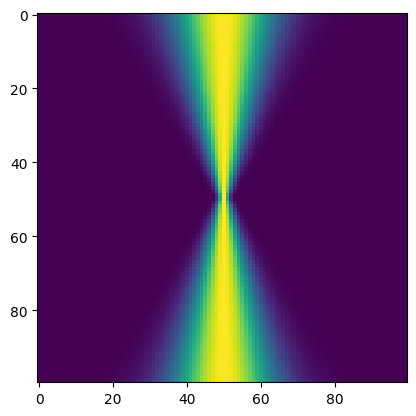

In [9]:
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d

kernels = [
    gaussian_kernel_1d(100, sigma)
    for sigma in
    # np.linspace(0.1, 0.01, 50)
    np.append(
        np.linspace(0.1, 0.01, 50),
        np.linspace(0.01, 0.1, 50),
    )
]

kernels = np.stack(kernels)
plt.imshow(kernels)

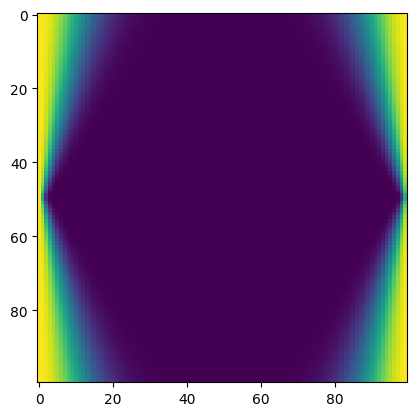

In [10]:
kernels = reorder_batched_array(
    kernels,
    create_index_matrix((100, ))[0]
)
plt.imshow(kernels)

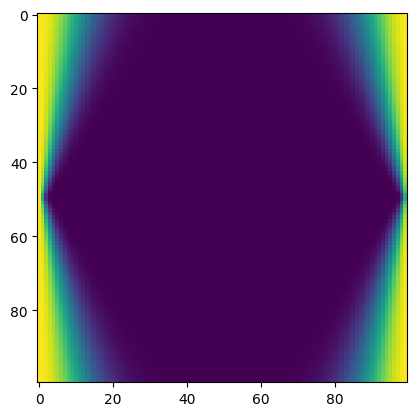

In [11]:
doubled = tensor2doubled(kernels)
plt.imshow(doubled)

In [12]:
def reorder_doubled_array(
    matrix: np.ndarray,
    indices: tuple[np.ndarray]
) -> np.ndarray:
    matrix_reshaped = matrix.reshape(*[np.prod(index.shape) for index in indices])
    matrix_reshaped[:] = matrix_reshaped[*np.ix_(*[index.flatten() for index in indices])]
    return matrix

In [13]:
shape = tuple(dim for i, dim in enumerate(doubled.shape) if i % 2)

reordered = reorder_doubled_array(
    # doubled,
    np.arange(100*100).reshape(100, 100),
    unbind_shifted_dims(shifted_1d(*(np.arange(i) for i in shape)))
)

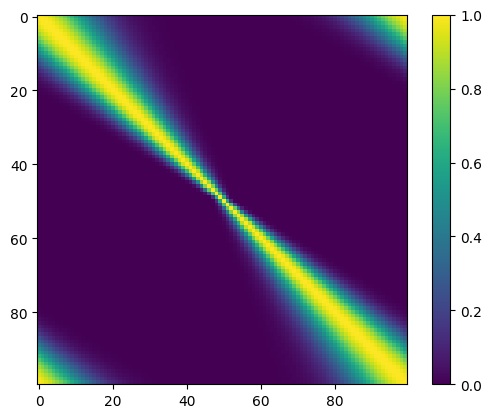

In [14]:
weights = doubled2weights(doubled)
im = plt.imshow(weights)
plt.colorbar(im)

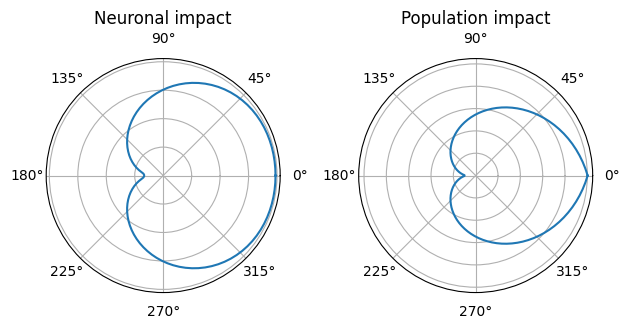

In [140]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar')

ax1.plot(np.linspace(0, 2*np.pi, 100), weights.sum(0))
ax1.set_title('Neuronal impact')
ax1.axes.yaxis.set_ticklabels([])
ax2.plot(np.linspace(0, 2*np.pi, 100), weights.sum(1))
ax2.set_title('Population impact')
ax2.axes.yaxis.set_ticklabels([])
fig.tight_layout()

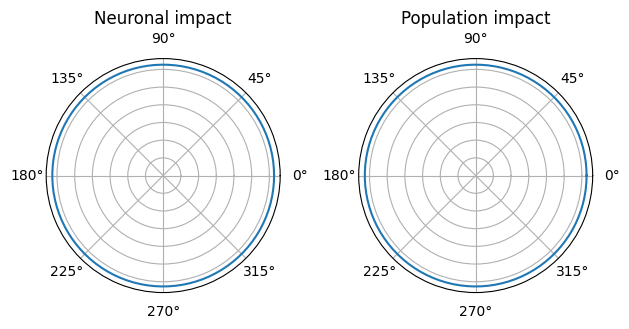

In [133]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar')

ax1.plot(np.linspace(0, 2*np.pi, 100), weights.sum(0))
ax1.set_title('Neuronal impact')
ax1.axes.yaxis.set_ticklabels([])
ax2.plot(np.linspace(0, 2*np.pi, 100), weights.sum(1))
ax2.set_title('Population impact')
ax2.axes.yaxis.set_ticklabels([])
fig.tight_layout()

In [34]:
weights[-1, :].mean(), weights[:, -1].mean()

(0.025066282880429086, 0.1255070335774846)

In [36]:
weights[-1, :].mean(), weights[80, :].mean()

(0.025066282880429086, 0.06836258930811817)

In [39]:
weights[:, -1].mean(), weights[:, 80].mean()

(0.1255070335774846, 0.07540334266259105)

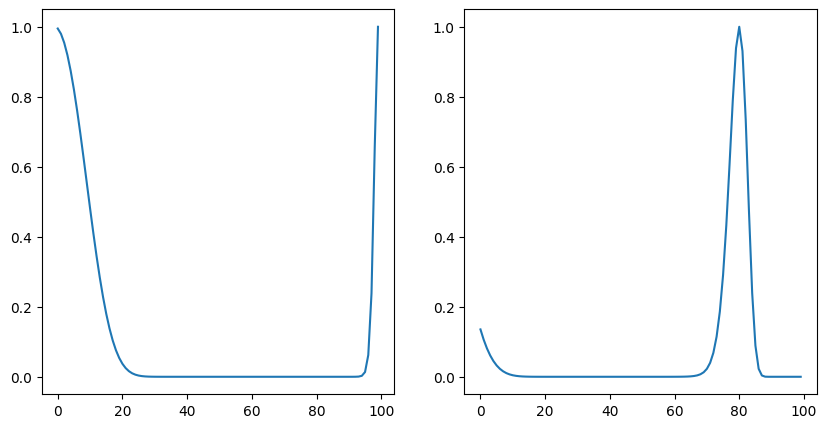

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(weights[:, -1])
ax2.plot(weights[:, 80])

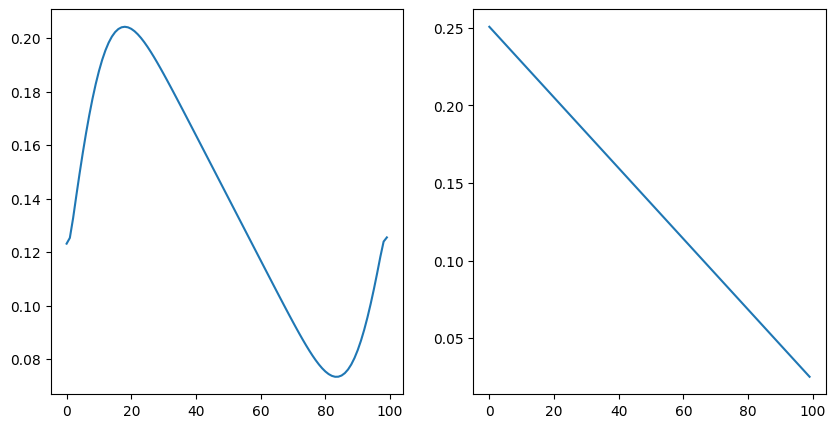

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(weights.mean())
ax2.plot(weights.mean(1))

In [14]:
from abc import ABC, abstractmethod
from bbtoolkit.utils.datautils import Copyable, WritablePickle
import numpy as np

class AbstractAttractorState(Copyable, WritablePickle, ABC):
    """
    An abstract class representing the state of an attractor system. This class defines the basic structure and required methods for any attractor state implementation.

    Attributes:
        kernel (np.ndarray): The kernel array representing the attractor's influence pattern.
        state (np.ndarray): The current state of the system.
        indexer (AttractorIndexer): An indexer object to handle wrapping and indexing logic.
        inplace (bool): If True, operations modify the state in place. Defaults to False.
        weights (np.ndarray, optional): An array of weights for the state transformation. If None, no weighting is applied.
    """
    def __init__(
        self,
        kernel: np.ndarray,
        state: np.ndarray,
        indexer: AttractorIndexer,
        weights: np.ndarray
    ):
        """
        Initializes the AbstractAttractorState with a kernel, state, and optional weights.

        Args:
            kernel (np.ndarray): The kernel array.
            state (np.ndarray): The current state array.
            indexer (AttractorIndexer): The indexer object for handling indexing.
            weights (np.ndarray, optional): An array of weights for state transformation. Defaults to None.
        """
        self.kernel = kernel
        self.state = state
        self.indexer = indexer
        self.weights = weights

    @property
    @abstractmethod
    def kernel(self):
        """
        Abstract property that should return the current kernel array.

        Returns:
            np.ndarray: The current kernel array.
        """
        pass

    @property
    @abstractmethod
    def shape(self):
        """
        Abstract property that should return the shape of the kernel.

        Returns:
            tuple[int, ...]: The shape of the kernel array.
        """
        pass

    @property
    @abstractmethod
    def ndim(self):
        """
        Abstract property that should return the number of dimensions of the kernel.

        Returns:
            int: The number of dimensions of the kernel array.
        """
        pass

    @abstractmethod
    def __getitem__(self, indices: np.ndarray):
        """
        Abstract method for indexing into the attractor state.

        Args:
            indices (np.ndarray): The indices to access.

        Returns:
            np.ndarray: The result of applying the kernel and indexer to the state at the given indices.
        """
        pass

    @abstractmethod
    def __matmul__(self, other: np.ndarray):
        """
        Abstract method for transforming an array based on the attractor state.

        Args:
            other (np.ndarray): The array to be transformed by the attractor state.

        Returns:
            np.ndarray: The transformed array.
        """
        pass

    @abstractmethod
    def values(self, weights: np.ndarray = None) -> np.ndarray:
        """
        Abstract method that should return the weighted state if weights are provided, otherwise some default state representation.

        Args:
            weights (np.ndarray, optional): The weights to apply to the state. If None, precomputed weights are used. Defaults to None.

        Returns:
            np.ndarray: The weighted state or a default state representation.
        """
        pass


class AbstractAttractor(Copyable, WritablePickle, ABC):
    """
    An abstract class representing an attractor system. This class defines the basic structure and required methods for any attractor implementation.

    Attributes:
        kernel (np.ndarray): The kernel array representing the attractor's influence pattern.
        precompute (bool): If True, precomputes weights for the attractor. Defaults to False.
        shape (tuple[int, ...], optional): The shape of the attractor system. If None, derived from the kernel. Defaults to None.
    """
    def __init__(
        self,
        kernel: np.ndarray,
        inplace: bool = False,
        shape: tuple[int, ...] = None,
    ):
        """
        Initializes the AbstractAttractor with a kernel and optional inplace modification, precomputation settings, and shape.

        Args:
            kernel (np.ndarray): The kernel array.
            inplace (bool, optional): If True, operations modify the state in place. Defaults to False.
            shape (tuple[int, ...], optional): The shape of the attractor system. If None, derived from the kernel.
        """

        if shape is None:
            shape = kernel.shape

        self.inplace = inplace
        self.indexer = AttractorIndexer(shape)
        self.weights = None
        self.kernel = kernel

    @property
    @abstractmethod
    def kernel(self):
        """
        Abstract property that should return the current kernel array.

        Returns:
            np.ndarray: The current kernel array.
        """
        pass

    @property
    @abstractmethod
    def shape(self):
        """
        Abstract property that should return the shape of the attractor system.

        Returns:
            tuple[int, ...]: The shape of the attractor system.
        """
        pass

    @property
    @abstractmethod
    def ndim(self):
        """
        Abstract property that should return the number of dimensions of the attractor system.

        Returns:
            int: The number of dimensions of the attractor system.
        """
        pass

    @abstractmethod
    def __len__(self):
        """
        Abstract method that should return the length of the attractor system, typically the number of elements or states.

        Returns:
            int: The length of the attractor system.
        """
        pass

    @abstractmethod
    def __call__(self, *args):
        """
        Abstract method that should allow the attractor object to be called like a function, typically to apply the attractor transformation to some input.

        Args:
            *args: Variable length argument list for the attractor transformation.

        Returns:
            Any: The result of the attractor transformation.
        """
        pass

    @abstractmethod
    def get_weights(self):
        """
        Abstract method that should compute and return the weights matrix based on the kernel, used for transforming states.

        Returns:
            np.ndarray: The weights matrix derived from the kernel.
        """
        pass

## SELF-CONNECTED ATTRACTOR

In [15]:
from bbtoolkit.utils.datautils import Cached


class SelfAttractorState(AbstractAttractorState):
    """
    Represents the state of a self-attractor system, allowing for interaction with a kernel and state array.
    """
    def __init__(
        self,
        kernel: np.ndarray,
        state: np.ndarray,
        indexer: AttractorIndexer,
        weights: np.ndarray,
        cache_manager: Cached = None
    ):
        """
        Initializes the SelfAttractorState with a kernel, state, and optional weights.

        Args:
            kernel (np.ndarray): The kernel array.
            state (np.ndarray): The current state array.
            indexer (AttractorIndexer): The indexer object for handling indexing.
            weights (np.ndarray, optional): An array of weights for state transformation. Defaults to None.
            cache_manager (Cached, optional): A cache manager object for memoization. Defaults to None.
        """
        self.cache_manager = cache_manager if cache_manager is not None else Cached()
        super().__init__(
            kernel,
            state,
            indexer,
            weights
        )

    @property
    def kernel(self):
        """
        Property to get or set the kernel. Setting the kernel also updates the shifted kernel and precomputes weights if enabled.

        Returns:
            np.ndarray: The current kernel array.
        """
        return self._kernel

    @kernel.setter
    def kernel(self, value: np.ndarray):
        self._kernel = value
        self._kernel_shifted = self.kernel[create_index_matrix(self.kernel.shape)]

    @property
    def shape(self):
        """
        Returns the shape of the kernel.

        Returns:
            tuple: The shape of the kernel array.
        """
        return self.kernel.shape

    @property
    def ndim(self):
        """
        Returns the number of dimensions of the kernel.

        Returns:
            int: The number of dimensions of the kernel array.
        """
        return self.kernel.ndim

    def __len__(self):
        """
        Returns the length of the kernel.

        Returns:
            int: The length of the kernel array.
        """
        return len(self.kernel)

    def __getitem__(self, indices: np.ndarray):
        """
        Allows indexing into the attractor state, applying the kernel and indexer logic.

        Args:
            indices (np.ndarray): The indices to access.

        Returns:
            np.ndarray: The result of applying the kernel and indexer to the state at the given indices.
        """
        indices = wrap_indices(indices, self.kernel.shape)

        return select_data(self.state, self.indexer[indices])*self._kernel_shifted[*indices]

    def __matmul__(self, other: np.ndarray):
        """
        Implements the matrix multiplication operation, transforming the 'other' array based on the attractor state.

        Args:
            other (np.ndarray): The array to be transformed by the attractor state.

        Returns:
            np.ndarray: The transformed array.
        """
        @self.cache_manager
        def nested_call(other: np.ndarray) -> np.ndarray:
            return self.values(get_attractor_weights(self.kernel + other))

        return nested_call(other)

    def values(self, weights: np.ndarray = None) -> np.ndarray:
        """
        Returns the weighted state if weights are provided, otherwise the result of matrix multiplication with a zero array.

        Args:
            weights (np.ndarray, optional): An array of weights for state transformation. If None, precomputed weights are used. Defaults to None.

        Returns:
            np.ndarray: The weighted state or the result of the attractor operation on a zero array.
        """
        weights = weights if weights is not None else self.weights
        state = self.state.copy()
        original_shape = state.shape
        state = np.reshape(state, (-1, self.weights.shape[-1]))
        state = np.transpose(state, (1, 0))
        state = weights@state
        state = np.transpose(state, (1, 0))
        return np.reshape(state, original_shape)


class SelfAttractor(AbstractAttractor):
    """
    Represents a self-attractor system capable of transforming states based on a kernel.
    """
    def __init__(
        self,
        kernel: np.ndarray,
        inplace: bool = False,
        cache_manager: Cached = None
    ):
        """
        Initializes the SelfAttractor with a kernel and optional inplace modification and precomputation settings.

        Args:
            kernel (np.ndarray): The kernel array representing the attractor's influence pattern.
            inplace (bool, optional): Whether to modify states in place. Defaults to False.
            precompute (bool, optional): Whether to precompute weights for the attractor. Defaults to False.
            cache_manager (Cached, optional): A cache manager object for memoization. Defaults to None.
        """
        self.cache_manager = cache_manager if cache_manager is not None else Cached()
        super().__init__(
            kernel,
            inplace,
        )

    @property
    def kernel(self):
        """
        Property to get or set the kernel. Setting the kernel also updates the shifted kernel and precomputes weights if enabled.

        Returns:
            np.ndarray: The current kernel array.
        """
        return self._kernel

    @kernel.setter
    def kernel(self, value: np.ndarray):
        """
        Sets the kernel array and updates the shifted kernel and precomputes weights if enabled.

        Args:
            value (np.ndarray): The new kernel array.
        """
        self._kernel = value
        self.weights = self.get_weights()

    @property
    def shape(self):
        """
        Returns the shape of the kernel.

        Returns:
            tuple: The shape of the kernel array.
        """
        return self.kernel.shape

    @property
    def ndim(self):
        """
        Returns the number of dimensions of the kernel.

        Returns:
            int: The number of dimensions of the kernel array.
        """
        return self.kernel.ndim

    def __len__(self):
        """
        Returns the length of the kernel.

        Returns:
            int: The length of the kernel array.
        """
        return len(self.kernel)

    def __call__(self, state: np.ndarray) -> SelfAttractorState:
        """
        Allows the object to be called like a function, returning a new SelfAttractorState based on the provided state.

        Args:
            state (np.ndarray): The state array to be transformed by the attractor.

        Returns:
            SelfAttractorState: A new SelfAttractorState object initialized with the current kernel and the provided state.
        """
        if not self.inplace:
            state = state.copy()

        return SelfAttractorState(self.kernel, state, self.indexer, self.weights, self.cache_manager)

    def get_weights(self) -> np.ndarray:
        """
        Computes and returns the weights matrix based on the kernel, used for transforming states.

        Returns:
            np.ndarray: The weights matrix derived from the kernel.
        """
        @self.cache_manager
        def nested_call(kernel: np.ndarray) -> np.ndarray:
            return get_attractor_weights(kernel)

        return nested_call(self.kernel.copy())

In [16]:
m, n = 100, 100
attr = SelfAttractor(
    create_ricker_matrix(m, n)
)

attr_p = SelfAttractor(
    create_ricker_matrix(m, n)
)

t1 = time.time()
weights = attr.get_weights()
# shape = weights.shape
# side = np.prod(shape[:len(shape)//2])
# weights = np.reshape(weights, (side, side))
print(f'Runtime for pre-computing weights: {time.time() - t1}')

Runtime for pre-computing weights: 0.0013451576232910156


In [282]:
m, n = 100, 100
kernel = create_ricker_matrix(m, n)

t1 = time.time()
weights2 = get_attractor_weights(
    kernel
)
print(f'Runtime: {time.time() - t1}')
print(
    np.all(
        weights2 == weights
    )
)

Runtime: 3.4818055629730225
True


### 1D ATTRACTOR WITH GAUSSIAN KERNEL

In [283]:
n = 100
attr = SelfAttractor(
    get_gaussian_kernel(
        n,
        center=0.5,
        sigma=0.05
    )
)
weights = attr.get_weights()
w = np.random.random([10, *attr.kernel.shape])
res1 = (w@weights)
res2 = attr(w).values()

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}')

Attractor is equal to dot product: True


#### KERNEL

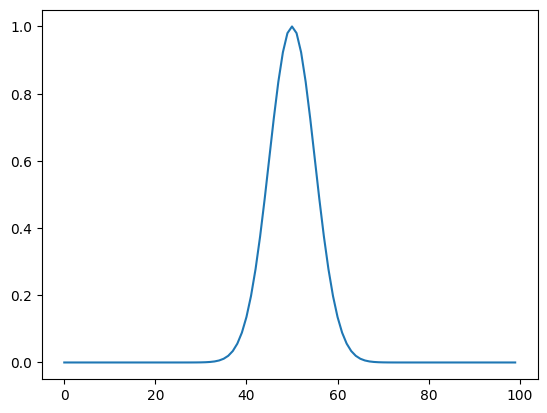

In [284]:
plt.plot(attr.kernel)

#### WEIGHTS

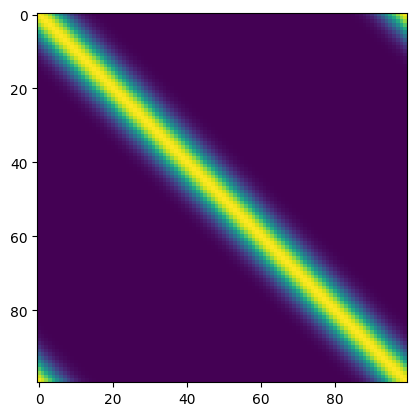

In [285]:
plt.imshow(weights)

#### DIMENSIONALITY CHECK

In [286]:
n = 100
attr = SelfAttractor(
    get_gaussian_kernel(
        n,
        center=0.5,
        sigma=0.05
    )[None, :]
)
weights = attr.get_weights()
w = np.random.random(attr.kernel.shape)

res1 = (weights@np.reshape(w, (weights.shape[0],)))
res2 = attr(w).values()

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}')

Attractor is equal to dot product: True


#### NATIVE VS PRE-COMPUTED

In [287]:
n = 100

# native
attr = SelfAttractor(
    get_gaussian_kernel(
        n,
        center=0.5,
        sigma=0.05
    )[None, :]
)

# pre-computed
attr_p = SelfAttractor(
    get_gaussian_kernel(
        n,
        center=0.5,
        sigma=0.05
    )
)
weights = attr.get_weights()
w = np.random.random([2, 1, 2, *attr.kernel.shape])

original_shape = w.shape
w = w.reshape(-1, weights.shape[-1])
t1 = time.time()
res1 = w@weights
res1 = np.reshape(res1, original_shape)
print(f'Runtime for matrix multiplication: {time.time() - t1}')

w = w.reshape(original_shape)

t1 = time.time()
res2 = attr(w).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(w).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')

Runtime for matrix multiplication: 0.0001049041748046875
Runtime for native attractor: 0.0003459453582763672
Runtime for pre-computed attractor: 0.0001266002655029297
Attractor is equal to dot product: True, True


### 2D ATTRACTOR WITH RICKER KERNEL

#### m=n, input shape = (2, 1, 2, m, n)

In [288]:
m, n = 100, 100
attr = SelfAttractor(
    create_ricker_matrix(m, n)
)

attr_p = SelfAttractor(
    create_ricker_matrix(m, n)
)
weights = attr.get_weights()
shape = weights.shape
side = np.prod(shape[:len(shape)//2])
weights = np.reshape(weights, (side, side))
w = np.random.random([2, 1, 2, *attr.kernel.shape])

original_shape = w.shape
w = w.reshape(-1, weights.shape[-1])
t1 = time.time()
res1 = w@weights
res1 = np.reshape(res1, original_shape)
print(f'Runtime for matrix multiplication: {time.time() - t1}')

w = w.reshape(original_shape)

t1 = time.time()
res2 = attr(w).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(w).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')
print(f'Input (State) shape: {w.shape}\nWeights shape: {weights.shape}\nKernel shape: {attr.kernel.shape}\n')

Runtime for matrix multiplication: 0.2592952251434326
Runtime for native attractor: 0.15972018241882324
Runtime for pre-computed attractor: 0.17160415649414062
Attractor is equal to dot product: True, True
Input (State) shape: (2, 1, 2, 100, 100)
Weights shape: (10000, 10000)
Kernel shape: (100, 100)



#### KERNEL

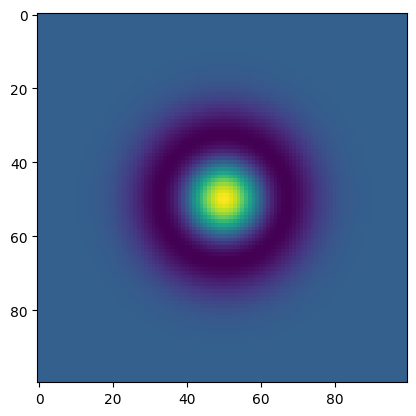

In [267]:
plt.imshow(attr.kernel)

#### WEIGHTS

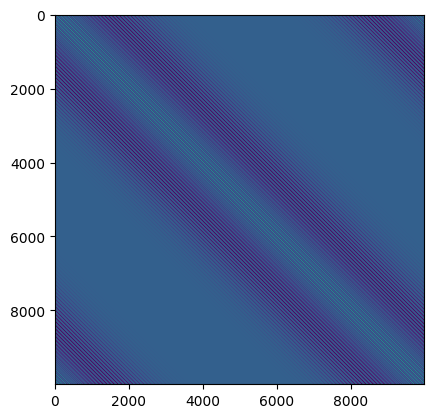

In [268]:
plt.imshow(weights)

#### m!=n, input shape = (2, 1, 2, m, n)

In [270]:
m, n = 50, 100
attr = SelfAttractor(
    create_ricker_matrix(m, n)
)

attr_p = SelfAttractor(
    create_ricker_matrix(m, n)
)
weights = attr.get_weights()
shape = weights.shape
side = np.prod(shape[:len(shape)//2])
weights = np.reshape(weights, (side, side))
w = np.random.random([2, 1, 2, *attr.kernel.shape])

original_shape = w.shape
w = w.reshape(-1, weights.shape[-1])
t1 = time.time()
res1 = w@weights
res1 = np.reshape(res1, original_shape)
print(f'Runtime for matrix multiplication: {time.time() - t1}')

w = w.reshape(original_shape)

t1 = time.time()
res2 = attr(w).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(w).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')
print(f'Input (State) shape: {w.shape}\nWeights shape: {weights.shape}\nKernel shape: {attr.kernel.shape}\n')

Runtime for matrix multiplication: 0.06367635726928711
Runtime for native attractor: 0.03542757034301758
Runtime for pre-computed attractor: 0.03870344161987305
Attractor is equal to dot product: True, True
Input (State) shape: (2, 1, 2, 50, 100)
Weights shape: (5000, 5000)
Kernel shape: (50, 100)



#### KERNEL

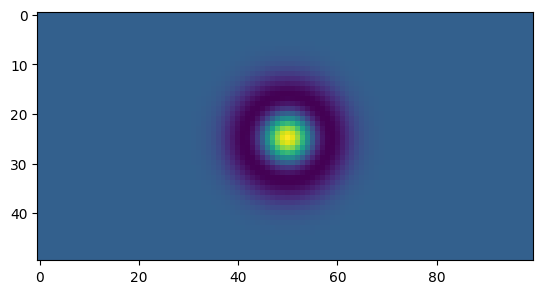

In [271]:
plt.imshow(attr.kernel)

#### WEIGHTS

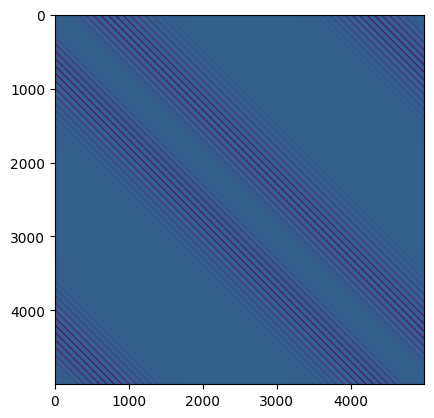

In [55]:
plt.imshow(weights)

### 3D ATTRACTOR WITH GAUSSIAN KERNEL

In [56]:
m, n, p = 10, 20, 30
w = create_gaussian_matrix_3d(m, n, p, 4)
attr = SelfAttractor(
    w,
    precompute=False
)

attr_p = SelfAttractor(
    w,
    precompute=True
)
weights = attr.get_weights()
# shape = weights.shape
# side = np.prod(shape[:len(shape)//2])
# weights = np.reshape(weights, (side, side))
w = np.random.random([2, 1, 2, *attr.kernel.shape])

original_shape = w.shape
w = w.reshape(-1, weights.shape[-1])
w = w.T
t1 = time.time()
res1 = weights@w
w = w.T
res1 = res1.T
res1 = np.reshape(res1, original_shape)
print(f'Runtime for matrix multiplication: {time.time() - t1}')

w = w.reshape(original_shape)

t1 = time.time()
res2 = attr(w).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(w).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')
print(f'Input (State) shape: {w.shape}\nWeights shape: {weights.shape}\nKernel shape: {attr.kernel.shape}\n')

Runtime for matrix multiplication: 0.05989527702331543
Runtime for native attractor: 1.0828144550323486
Runtime for pre-computed attractor: 0.05796098709106445
Attractor is equal to dot product: True, True
Input (State) shape: (2, 1, 2, 10, 20, 30)
Weights shape: (6000, 6000)
Kernel shape: (10, 20, 30)



#### KERNEL

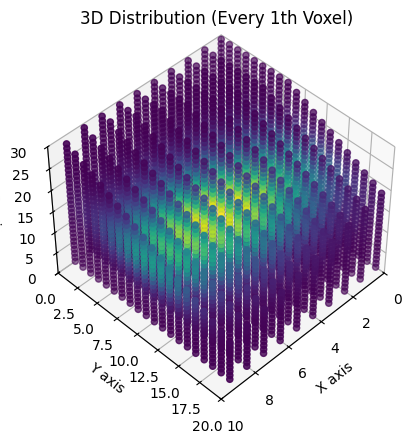

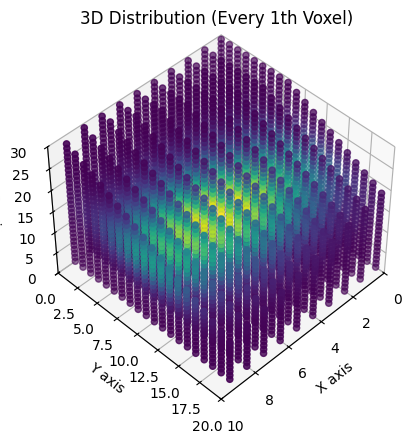

In [22]:
plot_3d_matrix(attr.kernel)

#### WEIGHTS

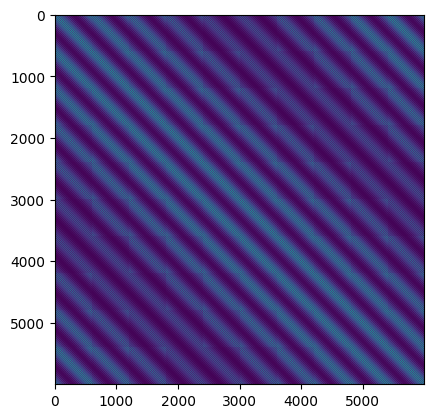

In [23]:
plt.imshow(weights)

## RING ATTRACTOR

In [19]:
class LoopAttractorState(SelfAttractorState):
    """
    Represents the state of a ring attractor system with multiple kernels and states.
    """
    def __init__(
        self,
        kernel: tuple[np.ndarray, ...],
        state: tuple[np.ndarray, ...],
        indexer: AttractorIndexer,
        weights: tuple[np.ndarray, ...] = None,
        cache_manager: Cached = None
    ):
        """
        Initializes the LoopAttractorState with kernels, states, and optional weights.

        Args:
            kernel (tuple[np.ndarray, ...]): The kernel arrays.
            state (tuple[np.ndarray, ...]): The current state arrays.
            indexer (AttractorIndexer): The indexer object for handling indexing.
            inplace (bool, optional): Whether to modify the states in place. Defaults to False.
            weights (tuple[np.ndarray, ...], optional): Arrays of weights for state transformation. Defaults to None.
            cache_manager (Cached, optional): A cache manager object for memoization. Defaults to None.
        """
        super().__init__(
            kernel,
            state,
            indexer,
            weights,
            cache_manager
        )
        self.state = list(self.state)
        self.state = tuple([self.state[-1]] + self.state[:-1])

    @property
    def kernel(self) -> tuple[np.ndarray, ...]:
        """
        Property to get or set the kernels. Setting the kernels also updates the shifted kernels and precomputes weights if enabled.

        Returns:
            tuple[np.ndarray, ...]: The current tuple of kernel arrays.
        """
        return self._kernel

    @kernel.setter
    def kernel(self, value: tuple[np.ndarray, ...]):
        """
        Sets the kernel arrays and updates the shifted kernels and precomputes weights if enabled.

        Args:
            value (tuple[np.ndarray, ...]): The new tuple of kernel arrays.
        """
        self._kernel = value
        self._kernel_shifted = tuple(
            kernel[create_index_matrix(kernel.shape)]
            for kernel in self.kernel
        )

    @property
    def shape(self) -> tuple[int, ...]:
        """
        Returns the shape of the first kernel.

        Returns:
            tuple[int, ...]: The shape of the first kernel array.
        """
        return self.kernel[0].shape

    @property
    def ndim(self) -> int:
        """
        Returns the number of dimensions of the first kernel.

        Returns:
            int: The number of dimensions of the first kernel array.
        """
        return self.kernel[0].ndim

    def __getitem__(self, indices: np.ndarray) -> tuple[np.ndarray, ...]:
        """
        Allows indexing into the ring attractor state, applying the kernels and indexer logic.

        Args:
            indices (np.ndarray): The indices to access.

        Returns:
            tuple[np.ndarray, ...]: The result of applying the kernels and indexer to the states at the given indices.
        """
        indices = wrap_indices(indices, self.shape)
        kernels = list(self._kernel_shifted)

        return tuple(
            select_data(
                state, self.indexer[indices]
            )*kernel[*indices]
            for state, kernel in zip(self.state, kernels)
        )

    def __matmul__(self, other: tuple[np.ndarray, ...]) -> tuple[np.ndarray, ...]:
        """
        Implements the matrix multiplication operation, transforming the 'other' tuple of arrays based on the attractor states.

        Args:
            other (tuple[np.ndarray, ...]): The tuple of arrays to be transformed by the attractor states.

        Returns:
            tuple[np.ndarray, ...]: The transformed tuple of arrays.
        """
        @self.cache_manager
        def nested_call(other: np.ndarray) -> np.ndarray:
            return self.values(get_attractor_weights(self.kernel + other))

        return tuple(nested_call(tensor) for tensor in other)

    def values(self) -> np.ndarray:
        """
        Returns the weighted states if weights are provided, otherwise the result of matrix multiplication with a tuple of zero arrays.

        Returns:
            np.ndarray: The weighted states or the result of the attractor operation on a tuple of zero arrays.
        """
        state = [s.copy() for s in self.state]
        original_shape = state[0].shape
        state = [s.reshape(-1, self.weights[0].shape[-1]) for s in state]
        state = [np.transpose(s, (1, 0)) for s in state]
        state = [weight@s for weight, s in zip(self.weights, state)]
        state = [np.transpose(s, (1, 0)) for s in state]
        state = [s.reshape(original_shape) for s in state]
        return state


class LoopAttractor(SelfAttractor):
    """
    Represents a ring attractor system capable of transforming states based on multiple kernels.

    Attributes:
        inplace (bool): If True, operations modify states in place. Defaults to False.
        precompute (bool): If True, precomputes weights for the attractor. Defaults to False.
        kernel (tuple[np.ndarray, ...]): The kernel arrays representing the attractor's influence patterns.
    """
    def __init__(
        self,
        kernel: tuple[np.ndarray, ...],
        inplace: bool = False,
        cache_manager: Cached = None
    ):
        """
        Initializes the LoopAttractor with kernels and optional inplace modification and precomputation settings.

        Args:
            kernel (tuple[np.ndarray, ...]): The kernel arrays.
            inplace (bool, optional): Whether to modify states in place. Defaults to False.
            precompute (bool, optional): Whether to precompute weights for the attractor. Defaults to False.
            cache_manager (Cached, optional): A cache manager object for memoization. Defaults to None.
        """
        self.cache_manager = cache_manager if cache_manager is not None else Cached(max_size=100*len(kernel))
        AbstractAttractor.__init__(
            self,
            kernel,
            inplace,
            kernel[0].shape,
        )

    @property
    def shape(self) -> tuple[int, ...]:
        """
        Returns the shape of the first kernel.

        Returns:
            tuple[int, ...]: The shape of the first kernel array.
        """
        return self.kernel[0].shape

    @property
    def ndim(self) -> int:
        """
        Returns the number of dimensions of the first kernel.

        Returns:
            int: The number of dimensions of the first kernel array.
        """
        return self.kernel[0].ndim

    def __call__(self, *weights: tuple[np.ndarray, ...]) -> LoopAttractorState:
        """
        Allows the object to be called like a function, returning a new LoopAttractorState based on the provided weights.

        Args:
            *weights (tuple[np.ndarray, ...]): The weights arrays to be transformed by the attractor.

        Returns:
            LoopAttractorState: A new LoopAttractorState object initialized with the current kernels and the provided weights.
        """
        if not self.inplace:
            weights = tuple(weight.copy() for weight in weights)

        return LoopAttractorState(self.kernel, weights, self.indexer, self.weights, self.cache_manager)

    def get_weights(self) -> tuple[np.ndarray, ...]:
        """
        Computes and returns the weights matrices based on the kernels, used for transforming states.

        Returns:
            tuple[np.ndarray, ...]: The tuple of weights matrices derived from the kernels.
        """
        @self.cache_manager
        def nested_call(kernel: np.ndarray) -> np.ndarray:
            return get_attractor_weights(kernel)

        return tuple(nested_call(kernel) for kernel in self.kernel)

### 2-RING 1D ATTRACTOR WITH GAUSSIAN KERNEL

In [20]:
attr = LoopAttractor((
    get_gaussian_kernel(
        100,
        center=0.5,
        sigma=0.05
    ),
    (get_gaussian_kernel(
        100,
        center=0.,
        sigma=0.05
    ) - .5)
))

attr_p = LoopAttractor((
    get_gaussian_kernel(
        100,
        center=0.5,
        sigma=0.05
    ),
    (get_gaussian_kernel(
        100,
        center=0.,
        sigma=0.05
    ) - .5)
))

w1, w2 = attr.get_weights()
r1, r2 = np.random.random(attr.kernel[0].shape).T, np.random.random(attr.kernel[1].shape).T
t1 = time.time()
res1 = w1@r2, w2@r1
print(f'Runtime for matrix multiplication: {time.time() - t1}')

t1 = time.time()
res2 = attr(r1, r2).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(r1, r2).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(
    f'Attractor is equal to dot product: {all([np.all(np.isclose(r1, r2)) for r1, r2 in zip(res1, res2)])}, '
    f'{all([np.all(np.isclose(r1, r2)) for r1, r2 in zip(res1, res3)])}'
)


Runtime for matrix multiplication: 0.0001838207244873047
Runtime for native attractor: 0.0005860328674316406
Runtime for pre-computed attractor: 0.0005941390991210938
Attractor is equal to dot product: True, True


#### KERNEL

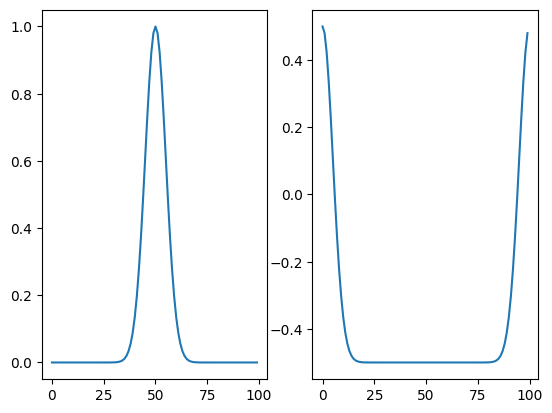

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(attr.kernel[0])
ax2.plot(attr.kernel[1])

#### WEIGHTS

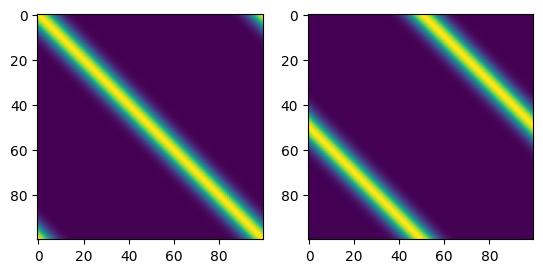

In [360]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(w1)
ax2.imshow(w2)

### 2-RING 2D ATTRACTOR WITH RICKER KERNEL

#### m=n, input shape = (2, 1, 2, m, n)

In [21]:
n, m = 10, 10

attr = LoopAttractor((
    create_ricker_matrix(
        n, m, 2
    ),
    create_ricker_matrix(
        n, m, 4
    )
))

attr_p = LoopAttractor((
    create_ricker_matrix(
        n, m, 2
    ),
    create_ricker_matrix(
        n, m, 4
    )
))


weights = attr.get_weights()
shape = weights[0].shape
side = np.prod(shape[:len(shape)//2])
weights = tuple(weight.reshape(side, side) for weight in weights)

w1, w2 = weights
r1, r2 = np.random.random((2, 1, 2, *attr.kernel[0].shape)), np.random.random((2, 1, 2, *attr.kernel[1].shape))


state = [s.copy() for s in (r1, r2)]
state = [state[-1]] + state[:-1]
original_shape = state[0].shape

t1 = time.time()
state = [s.reshape(-1, weights[0].shape[-1]) for s in state]
state = [np.transpose(s, (1, 0)) for s in state]
state = [weight@s for weight, s in zip(weights, state)]
state = [np.transpose(s, (1, 0)) for s in state]
res1 = [s.reshape(original_shape) for s in state]
print(f'Runtime for matrix multiplication: {time.time() - t1}')

t1 = time.time()
res2 = attr(r1, r2).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(r1, r2).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')
print(f'Input (State) shapes: {r1.shape, r2.shape}\nWeights shape: {w1.shape, w2.shape}\nKernel shape: {attr.kernel[0].shape, attr.kernel[1].shape}\n')


Runtime for matrix multiplication: 0.0004115104675292969
Runtime for native attractor: 0.00032639503479003906
Runtime for pre-computed attractor: 0.0002696514129638672
Attractor is equal to dot product: True, True
Input (State) shapes: ((2, 1, 2, 10, 10), (2, 1, 2, 10, 10))
Weights shape: ((100, 100), (100, 100))
Kernel shape: ((10, 10), (10, 10))



#### KERNEL

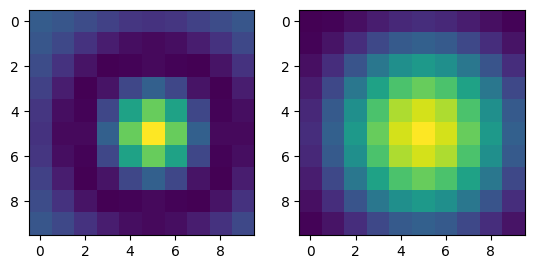

In [362]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(attr.kernel[0])
ax2.imshow(attr.kernel[1])

#### WEIGHTS

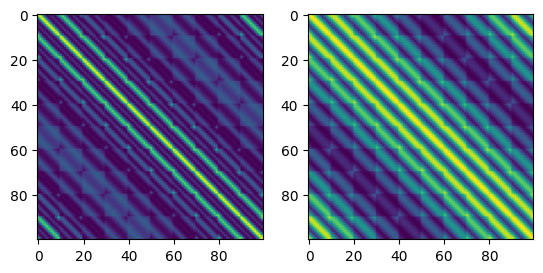

In [363]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(w1)
ax2.imshow(w2)

#### m!=n, input shape = (2, 1, 2, m, n)

In [22]:
n, m = 10, 20

attr = LoopAttractor((
    create_ricker_matrix(
        n, m, 2
    ),
    create_ricker_matrix(
        n, m, 4
    )
))

attr_p = LoopAttractor((
    create_ricker_matrix(
        n, m, 2
    ),
    create_ricker_matrix(
        n, m, 4
    )
))


weights = attr.get_weights()
shape = weights[0].shape
side = np.prod(shape[:len(shape)//2])
weights = tuple(weight.reshape(side, side) for weight in weights)

w1, w2 = weights
r1, r2 = np.random.random((2, 1, 2, *attr.kernel[0].shape)), np.random.random((2, 1, 2, *attr.kernel[1].shape))


state = [s.copy() for s in (r1, r2)]
state = [state[-1]] + state[:-1]
original_shape = state[0].shape

t1 = time.time()
state = [s.reshape(-1, weights[0].shape[-1]) for s in state]
state = [np.transpose(s, (1, 0)) for s in state]
state = [weight@s for weight, s in zip(weights, state)]
state = [np.transpose(s, (1, 0)) for s in state]
res1 = [s.reshape(original_shape) for s in state]
print(f'Runtime for matrix multiplication: {time.time() - t1}')

t1 = time.time()
res2 = attr(r1, r2).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(r1, r2).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')

print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')
print(f'Input (State) shapes: {r1.shape, r2.shape}\nWeights shape: {w1.shape, w2.shape}\nKernel shape: {attr.kernel[0].shape, attr.kernel[1].shape}\n')

Runtime for matrix multiplication: 0.00045037269592285156
Runtime for native attractor: 0.0004665851593017578
Runtime for pre-computed attractor: 0.0009188652038574219
Attractor is equal to dot product: True, True
Input (State) shapes: ((2, 1, 2, 10, 20), (2, 1, 2, 10, 20))
Weights shape: ((200, 200), (200, 200))
Kernel shape: ((10, 20), (10, 20))



#### KERNEL

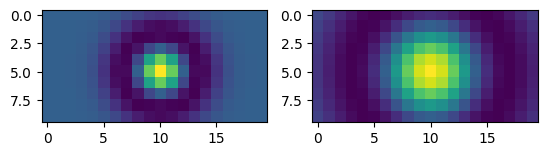

In [365]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(attr.kernel[0])
ax2.imshow(attr.kernel[1])

#### WEIGHTS

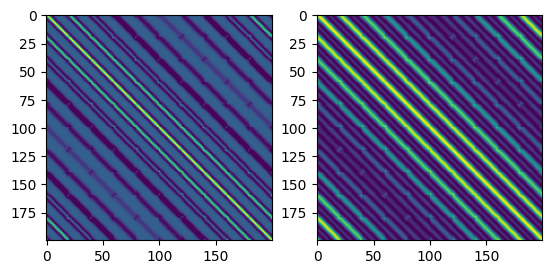

In [366]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(w1)
ax2.imshow(w2)

### 2-RING 3D ATTRACTOR WITH GAUSSIAN KERNEL

In [23]:
n, m, p = 10, 20, 30

w1, w2 = create_gaussian_matrix_3d(m, n, p, (5, 6, 2)),\
    create_gaussian_matrix_3d(m, n, p, (4, 3, 7))

attr = LoopAttractor((
    w1,
    w2
))

attr_p = LoopAttractor((
    w1,
    w2
))


weights = attr.get_weights()
# shape = weights[0].shape
# side = np.prod(shape[:len(shape)//2])
# weights = tuple(weight.reshape(side, side) for weight in weights)

w1, w2 = weights
r1, r2 = np.random.random(attr.kernel[0].shape), np.random.random(attr.kernel[1].shape)


state = [s.copy() for s in (r1, r2)]
state = [state[-1]] + state[:-1]
original_shape = state[0].shape

t1 = time.time()
state = [s.reshape(-1, weights[0].shape[-1]) for s in state]
state = [np.transpose(s, (1, 0)) for s in state]
state = [weight@s for weight, s in zip(weights, state)]
state = [np.transpose(s, (1, 0)) for s in state]
res1 = [s.reshape(original_shape) for s in state]
print(f'Runtime for matrix multiplication: {time.time() - t1}')

t1 = time.time()
res2 = attr(r1, r2).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(r1, r2).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')


print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')
print(f'Input (State) shapes: {r1.shape, r2.shape}\nWeights shape: {w1.shape, w2.shape}\nKernel shape: {attr.kernel[0].shape, attr.kernel[1].shape}\n')


Runtime for matrix multiplication: 0.028189897537231445
Runtime for native attractor: 0.026244640350341797
Runtime for pre-computed attractor: 0.02841353416442871
Attractor is equal to dot product: True, True
Input (State) shapes: ((20, 10, 30), (20, 10, 30))
Weights shape: ((6000, 6000), (6000, 6000))
Kernel shape: ((20, 10, 30), (20, 10, 30))



#### KERNEL

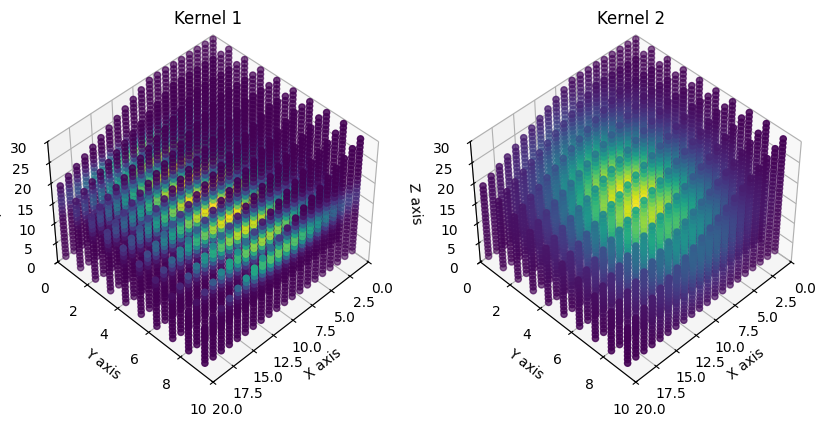

In [13]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

_ = plot_3d_matrix(attr.kernel[0], ax=ax1, title='Kernel 1')
_ = plot_3d_matrix(attr.kernel[1], ax=ax2, title='Kernel 2')

#### WEIGHTS

In [369]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(w1)
ax2.imshow(w2)

### 3-RING 3D ATTRACTOR WITH GAUSSIAN KERNEL

In [24]:
n, m, p = 5, 10, 15

k1, k2, k3 = (
    create_gaussian_matrix_3d(m, n, p, (5, 6, 2)),
    create_gaussian_matrix_3d(m, n, p, (3, 7, 4)),
    create_gaussian_matrix_3d(m, n, p, (4, 3, 7)),
    # create_gaussian_matrix_3d(m, n, p, (3, 7, 4))
)

attr = LoopAttractor((
    k1, k2, k3
))

attr_p = LoopAttractor((
    k1, k2, k3
))


weights = attr.get_weights()
# shape = weights[0].shape
# side = np.prod(shape[:len(shape)//2])
# weights = tuple(weight.reshape(side, side) for weight in weights)

rates = np.random.random(attr.kernel[0].shape), np.random.random(attr.kernel[1].shape), np.random.random(attr.kernel[2].shape)


state = [s.copy() for s in rates]
state = [state[-1]] + state[:-1]
original_shape = state[0].shape

t1 = time.time()
state = [s.reshape(-1, weights[0].shape[-1]) for s in state]
state = [np.transpose(s, (1, 0)) for s in state]
state = [weight@s for weight, s in zip(weights, state)]
state = [np.transpose(s, (1, 0)) for s in state]
res1 = [s.reshape(original_shape) for s in state]
print(f'Runtime for matrix multiplication: {time.time() - t1}')

t1 = time.time()
res2 = attr(*rates).values()
print(f'Runtime for native attractor: {time.time() - t1}')

t1 = time.time()
res3 = attr_p(*rates).values()
print(f'Runtime for pre-computed attractor: {time.time() - t1}')


print(f'Attractor is equal to dot product: {np.all(np.isclose(res1, res2))}, {np.all(np.isclose(res1, res3))}')

r1, r2, r3 = rates
w1, w2, w3 = weights
print(f'Input (State) shapes: {r1.shape, r2.shape, r3.shape}\nWeights shape: {w1.shape, w2.shape, w3.shape}\nKernel shape: {attr.kernel[0].shape, attr.kernel[1].shape, attr.kernel[2].shape}\n')

Runtime for matrix multiplication: 0.0010230541229248047
Runtime for native attractor: 0.0010879039764404297
Runtime for pre-computed attractor: 0.0008823871612548828
Attractor is equal to dot product: True, True
Input (State) shapes: ((10, 5, 15), (10, 5, 15), (10, 5, 15))
Weights shape: ((750, 750), (750, 750), (750, 750))
Kernel shape: ((10, 5, 15), (10, 5, 15), (10, 5, 15))



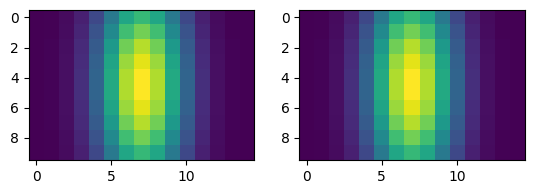

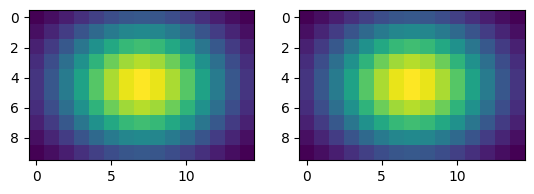

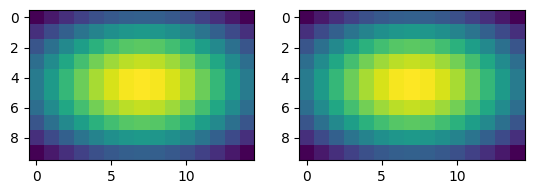

In [25]:
kernels = [k1, k2, k3]
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(weights[i][-1].reshape(10, 5, 15)[create_index_matrix((10, 5, 15))].mean(1))
    ax2.imshow(kernels[i].mean(1))
    plt.show()

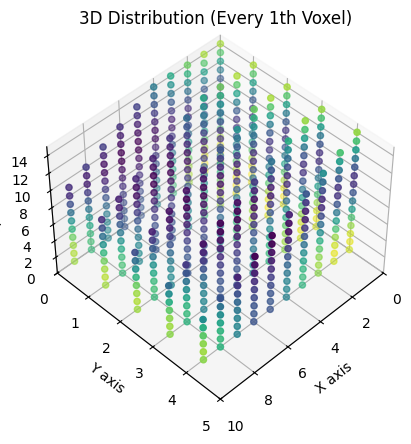

In [170]:
_ = plot_3d_matrix(weights[2][0].reshape(10, 5, 15))


#### KERNEL

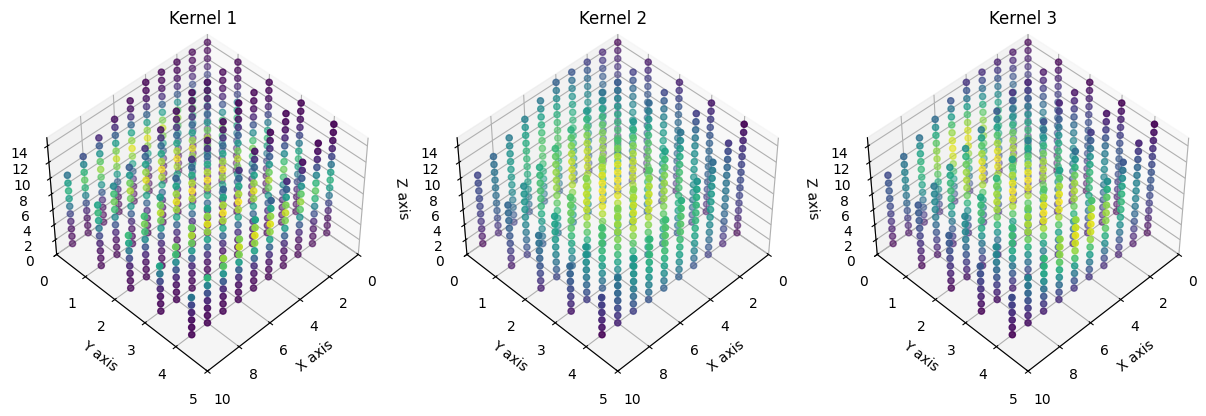

In [90]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

_ = plot_3d_matrix(attr.kernel[0], ax=ax1, title='Kernel 1')
_ = plot_3d_matrix(attr.kernel[1], ax=ax2, title='Kernel 2')
_ = plot_3d_matrix(attr.kernel[2], ax=ax3, title='Kernel 3')

#### WEIGHTS

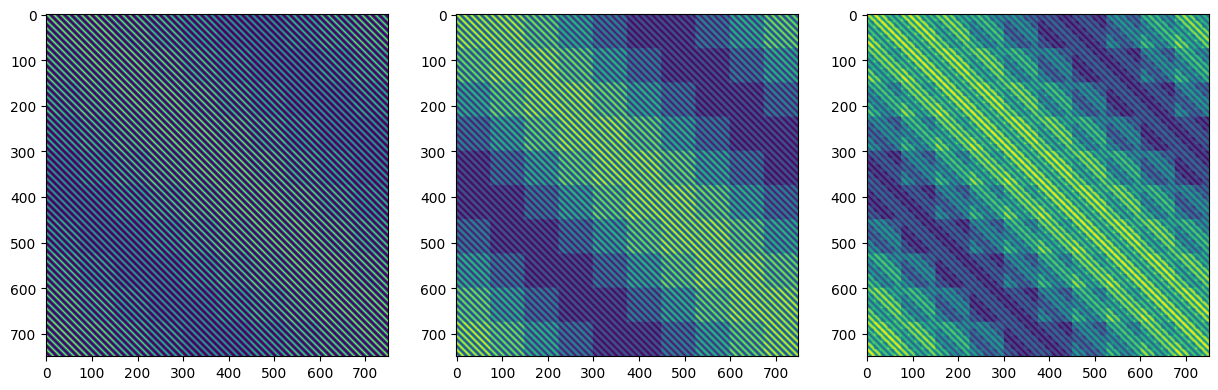

In [317]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(w1)
ax2.imshow(w2)
ax3.imshow(w3)